# How to wait for user input

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#human-in-the-loop). Waiting for human input is a common HIL interaction pattern, allowing the agent to ask the user clarifying questions and await input before proceeding. 

We can implement this in LangGraph using a [breakpoint](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/): breakpoints allow us to stop graph execution at a specific step. At this breakpoint, we can wait for human input. Once we have input from the user, we can add it to the graph state and proceed.



## Setup

First we need to install the packages required

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph 

In [2]:
%%capture --no-stderr
%pip install --quiet -U langchain_community  langchainhub  langchain langgraph langchain-groq

In [3]:
import os
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["GROQ_API_KEY"] ="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"

## Simple Usage

Let's look at very basic usage of this. One intuitive approach is simply to create a node, `human_feedback`, that will get user feedback. This allows us to place our feedback gathering at a specific, chosen point in our graph.
 
1) We specify the [breakpoint](https://langchain-ai.github.io/langgraph/concepts/low_level/#breakpoints) using `interrupt_before` our `human_feedback` node.

2) We set up a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer) to save the state of the graph up until this node.

3) We use `.update_state` to update the state of the graph with the human response we get.

* We [use the `as_node` parameter](https://langchain-ai.github.io/langgraph/concepts/low_level/#update-state) to apply this state update as the specified node, `human_feedback`.
* The graph will then resume execution as if the `human_feedback` node just acted.

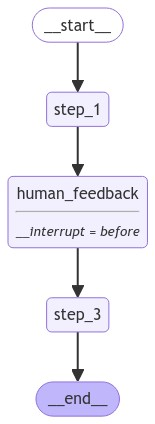

In [3]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Run until our breakpoint at `step_2` - 

In [4]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---


Now, we can just manually update our graph state with with the user input - 

In [45]:
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"user_feedback": user_input}, as_node="human_feedback")

# We can check the state
print("--State after update--")
print(graph.get_state(thread))

# We can check the next node, showing that it is node 3 (which follows human_feedback)
graph.get_state(thread).next

Tell me how you want to update the state:  go to step 3 


--State after update--
StateSnapshot(values={'input': 'hello world', 'user_feedback': 'go to step 3 '}, next=('step_3',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef5e3f2-2152-61db-8007-3305d9f3dcbb'}}, metadata={'source': 'update', 'step': 7, 'writes': {'human_feedback': {'user_feedback': 'go to step 3 '}}}, created_at='2024-08-19T15:24:31.953557+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef5e216-5233-66af-8006-f37b32a54f49'}})


('step_3',)

We can proceed after our breakpoint - 

In [9]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

---Step 3---


We can see our feedback was added to state - 

In [10]:
graph.get_state(thread).values

{'input': 'hello world', 'user_feedback': 'go to step 3'}

## Agent

In the context of agents, waiting for user feedback is useful to ask clarifying questions.
 
To show this, we will build a relatively simple ReAct-style agent that does tool calling. 

We will use one of the groq models and a fake tool (just for demo purposes).

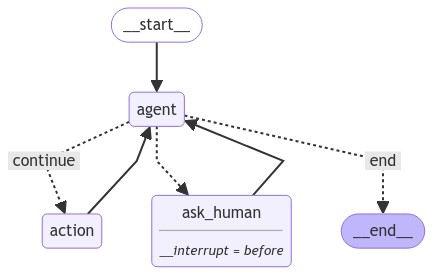

In [36]:
# Set up the state
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool - a search tool
# We'll also have one "fake" tool - a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool

def weather_search(city: str):
    """Search for the weather"""
    print("----")
    print(f"Searching for: {city}")
    print("----")
    return "Sunny!"
    
tools = [weather_search]
tool_node = ToolNode(tools)

# Set up the model

from langchain_groq import ChatGroq

model = ChatGroq(model="llama3-8b-8192")

# We are going "bind" all tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`

from langchain_core.pydantic_v1 import BaseModel


class AskHuman(BaseModel):
    """Ask the human a question"""

    question: str


model = model.bind_tools(tools + [AskHuman])

# Define nodes and conditional edges

from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]

    # Check if we need to ask the human first
    if last_message.content == "Use the search tool to ask the user where they are, then look up the weather there":
        return "ask_human"
    
    # If there's a tool call in the message, check what tool was invoked
    if last_message.tool_calls:
        # If tool call is asking the Human, we return that node
        if last_message.tool_calls[0]["name"] == "AskHuman":
            return "ask_human"
        # Otherwise, continue with the tool invocation
        return "continue"
    
    # If no tool calls and no special content, finish the workflow
    return "end"



# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}



def ask_human(state):
    pass


# Build the graph

from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("ask_human", ask_human)
workflow.add_node("action", tool_node)


# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # We may ask the human
        "ask_human": "ask_human",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
# We add a breakpoint BEFORE the `ask_human` node so it never executes
app = workflow.compile(checkpointer=memory, interrupt_before=["ask_human"])

display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
model

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000022912946000>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000022912970200>, model_name='llama3-8b-8192', groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'search', 'description': 'Call to surf the web.', 'parameters': {'type': 'object', 'properties': {'query': {'type': 'string'}}, 'required': ['query']}}}, {'type': 'function', 'function': {'name': 'AskHuman', 'description': 'Ask the human a question', 'parameters': {'type': 'object', 'properties': {'question': {'type': 'string'}}, 'required': ['question']}}}]})

## Interacting with the Agent

We can now interact with the agent. Let's ask it to ask the user where they are, then tell them the weather. 

This should make it use the `ask_human` tool first, then use the normal tool.

In [41]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(
    content="Use the search tool to ask the user where they are, then look up the weather there"
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Use the search tool to ask the user where they are, then look up the weather there
================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_3pen)
 Call ID: call_3pen
  Args:
    question: Where are you?


In [42]:
tool_call_id = app.get_state(config).values["messages"][-1].tool_calls[0]["id"]

# We now create the tool call with the id and the response we want
tool_message = [
    {"tool_call_id": tool_call_id, "type": "tool", "content": "Rabat"}
]

# # This is equivalent to the below, either one works
# from langchain_core.messages import ToolMessage
# tool_message = [ToolMessage(tool_call_id=tool_call_id, content="san francisco")]

# We now update the state
# Notice that we are also specifying `as_node="ask_human"`
# This will apply this update as this node,
# which will make it so that afterwards it continues as normal
app.update_state(config, {"messages": tool_message}, as_node="ask_human")

# We can check the state
# We can see that the state currently has the `agent` node next
# This is based on how we define our graph,
# where after the `ask_human` node goes (which we just triggered)
# there is an edge to the `agent` node
app.get_state(config).next

('agent',)

In [43]:
for event in app.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  weather_search (call_dkw4)
 Call ID: call_dkw4
  Args:
    city: Rabat
----
Searching for: Rabat
----
================================= Tool Message =================================
Name: weather_search

Sunny!
================================== Ai Message ==================================

The weather in Rabat is sunny!
